In [2]:
import torchaudio
import torch
import os

%load_ext autoreload
%autoreload 2

In [3]:
# load file at data/vcc2016_training/SF1/100001.wav
waveform, sample_rate = torchaudio.load('../data/vcc2016_training/SF1/100001.wav')
waveform.size()

torch.Size([1, 56314])

In [4]:
class Downsample(torch.nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
      super(Downsample, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.conv = torch.nn.Conv1d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
      self.norm = torch.nn.InstanceNorm1d(num_features=out_channels, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      """ [B, D, T] -> [B, D, T]"""
      x = self.conv(x)
      x = self.norm(x)
      x = self.glu(x)
      return x
  
class ResidualBlock(torch.nn.Module):
  def __init__(self, in_channels1, out_channels1, in_channels2, out_channels2, kernel_size, stride):
    super(ResidualBlock, self).__init__()
    self.conv1 = torch.nn.Conv1d(in_channels=in_channels1,
                                out_channels=out_channels1,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding='same')
    self.norm1 = torch.nn.InstanceNorm1d(num_features=out_channels1, affine=True)
    self.glu = torch.nn.GLU(dim=1)
    self.conv2 = torch.nn.Conv1d(in_channels=in_channels2,
                                out_channels=out_channels2,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding='same')
    self.norm2 = torch.nn.InstanceNorm1d(num_features=out_channels2, affine=True)
  
  def forward(self, x):
    """ [B, D, T] -> [B, D, T]"""
    residual = x.clone()
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.glu(x)
    x = self.conv2(x)
    x = self.norm2(x)
    return x + residual

# from https://github.com/serkansulun/pytorch-pixelshuffle1d
class PixelShuffle1D(torch.nn.Module):
    """
    1D pixel shuffler. https://arxiv.org/pdf/1609.05158.pdf
    Upscales sample length, downscales channel length
    "short" is input, "long" is output
    """
    def __init__(self, upscale_factor):
        super(PixelShuffle1D, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        """ [B, D, T] -> [B, D/upscale_factor, T*upscale_factor]"""
        batch_size = x.shape[0]
        short_channel_len = x.shape[1]
        short_width = x.shape[2]

        long_channel_len = short_channel_len // self.upscale_factor
        long_width = self.upscale_factor * short_width

        x = x.contiguous().view([batch_size, self.upscale_factor, long_channel_len, short_width])
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, long_channel_len, long_width)

        return x

class Upsample(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=(0, 0)):
      super(Upsample, self).__init__()
      self.conv = torch.nn.Conv1d(in_channels=in_channels,
                                          out_channels=out_channels,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding)
      self.pixel_shuffle = PixelShuffle1D(upscale_factor=2)
      self.norm = torch.nn.InstanceNorm1d(num_features=out_channels//2, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      x = self.conv(x)
      x = self.pixel_shuffle(x)
      x = self.norm(x)
      x = self.glu(x)
      return x

class Generator(torch.nn.Module):
    
    def __init__(self):
      super(Generator, self).__init__()
      self.conv1 = torch.nn.Conv1d(in_channels=24, out_channels=128, kernel_size=5, stride=1, padding=2)
      self.glu = torch.nn.GLU(dim=1)
      self.downsample_twice = torch.nn.Sequential(
        Downsample(in_channels=64, out_channels=256, kernel_size=5, stride=2, padding=2),
        Downsample(in_channels=128, out_channels=512*2, kernel_size=5, stride=2, padding=2),
      )
      self.residual_blocks = torch.nn.Sequential(
        *[ResidualBlock(in_channels1=512, out_channels1=1024,
                        in_channels2=512, out_channels2=512,
                        kernel_size=3, stride=1) for _ in range(6)]
      )
      self.upsample_twice = torch.nn.Sequential(
         Upsample(in_channels=512, out_channels=1024, kernel_size=5, stride=1, padding=2),
         Upsample(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
      )
      self.conv2 = torch.nn.Conv1d(in_channels=128, out_channels=24, kernel_size=15, stride=1, padding='same')

    def forward(self, x):
      """ [B, D, T] -> [B, D, T]
      B - batch size
      D - number of mel-cepstral coefficients
      T - number of time steps - 128 for training
      """
      x = self.conv1(x)
      x = self.glu(x)
      x = self.downsample_twice(x)
      x = self.residual_blocks(x)
      x = self.upsample_twice(x)
      x = self.conv2(x)
      return x

class Downsample2d(torch.nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=[0, 0]):
      super(Downsample2d, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.conv = torch.nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
      self.norm = torch.nn.InstanceNorm2d(num_features=out_channels, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      """ [B, D, T] -> [B, D, T]"""
      x = self.conv(x)
      x = self.norm(x)
      x = self.glu(x)
      return x

class Discriminator(torch.nn.Module):
   
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(3, 3), stride=(1, 2), padding=(1,1))
    self.glu = torch.nn.GLU(dim=1)
    
    self.d1 = Downsample2d(in_channels=64, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1,1))
    self.d2 = Downsample2d(in_channels=128, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(1,1))
    self.d3 = Downsample2d(in_channels=256, out_channels=1024, kernel_size=(6, 3), stride=(1, 2), padding=(0,0))
    
    self.fc = torch.nn.Linear(in_features=3584, out_features=1)
    self.sigmoid = torch.nn.Sigmoid()     

  def forward(self, x):
    x = self.conv1(x)
    x = self.glu(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = x.flatten(start_dim=1)
    x = self.fc(x)
    x = self.sigmoid(x)
    return x

In [5]:
def test_residual_block():
  residual = ResidualBlock(in_channels1=1024, out_channels1=1024, 
              in_channels2=512, out_channels2=1024,
              kernel_size=3, stride=1)

  residual.forward(torch.randn(1, 1024, 1024)).size()
test_residual_block()

def test_downsample_block():
  downsample = Downsample(in_channels=24, out_channels=256, kernel_size=5, stride=2)
  print(downsample.forward(torch.randn(1, 24, 1024)).size())
test_downsample_block()

def test_upsample_block():
  upsample1 = Upsample(in_channels=512, out_channels=1024, kernel_size=5, stride=1, padding=2)
  upsample2 = Upsample(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2)
  x = torch.randn(1, 512, 1024)
  x = upsample1.forward(x)
  x = upsample2.forward(x)
test_upsample_block()

def test_generator():
  generator = Generator()
  print(generator.forward(torch.randn(1, 24, 128)).size())
test_generator()

def test_discriminator():
  discriminator = Discriminator()
  print(discriminator.forward(torch.randn(1, 1, 24, 128)).size())
test_discriminator()

torch.Size([1, 128, 510])
torch.Size([1, 24, 128])
torch.Size([1, 1])


In [6]:
class CycleGAN(torch.nn.Module):
      
      def __init__(self):
        super(CycleGAN, self).__init__()
        self.Gx_y = Generator()
        self.Gy_x = Generator()
        self.Dy = Discriminator()
        self.Dx = Discriminator()

In [7]:
def test_cyclegan():
  cycleGAN = CycleGAN()

  # Forward-inverse mapping
  x = torch.randn(1, 24, 128)
  y_hat = cycleGAN.Gx_y.forward(x)
  print(f'y_hat: {y_hat.size()}')

  x_hat = cycleGAN.Gy_x.forward(y_hat)

  print(f'x_hat: {x_hat.size()}')
  x_hat = x_hat.unsqueeze(0)
  print(f'x_hat: {x_hat.size()}')

  print(f'Dy: {cycleGAN.Dy.forward(x_hat).size()}')

  # Inverse-forward mapping
  y = torch.randn(1, 24, 128)
  x_hat = cycleGAN.Gy_x.forward(y)
  y_hat = cycleGAN.Gx_y.forward(x_hat)

  x_hat = x_hat.unsqueeze(0)

  cycleGAN.Dx.forward(x_hat).size()

test_cyclegan()

y_hat: torch.Size([1, 24, 128])
x_hat: torch.Size([1, 24, 128])
x_hat: torch.Size([1, 1, 24, 128])
Dy: torch.Size([1, 1])


Epoch 0


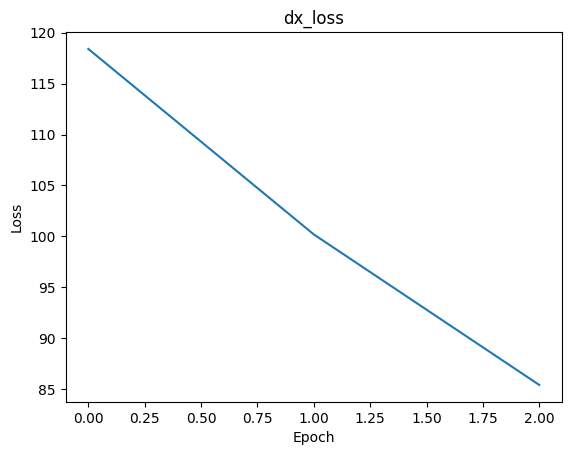

In [8]:
cyc_tradeoff_parameter=10
identity_tradeoff_parameter=5

def training_iteration(x,
                       y,
                       optimizer,
                       criterion, Gx_y, Gy_x, Dx, Dy):
  # A batch of training features
  batch_size = x.size()[0]
  # Create labels which are later used as input for the BCU loss
  real_labels = torch.ones(batch_size, 1)
  fake_labels = torch.zeros(batch_size, 1)

  # ======================================================== #
  #                      TRAIN DISCRIMINATORS                #
  # ======================================================== #

  def adversarial_loss(G, D, source, target):

    # Discriminator should learn to classify real and fake features
    # correctly. Thus we give it a set for real features with real labels
    # and a set of fake features with fake labels.
    real_outputs = D.forward(target.unsqueeze(0))
    d_loss_real = criterion(real_outputs, real_labels)
    real_score = real_outputs

    # Generate fake features
    # from IPython.core.debugger import Tracer; Tracer()() 
    z = source
    fake_features = G.forward(z)
    fake_outputs = D.forward(fake_features.unsqueeze(0))
    d_loss_fake = criterion(fake_outputs, fake_labels)
    fake_score = fake_outputs

    d_loss = d_loss_real + d_loss_fake
    return d_loss, real_score, fake_score

  dy_loss, real_score, fake_score = adversarial_loss(G=Gx_y, D=Dy, source=x, target=y)
  dx_loss, real_score, fake_score = adversarial_loss(G=Gy_x, D=Dx, source=y, target=x)


  # ======================================================== #
  #                      TRAIN GENERATORS                    #
  # ======================================================== #

  def cycle_consistency_loss(Gx_y, Gy_x, x, y):
    forward_loss = torch.norm(Gy_x.forward(Gx_y.forward(x)) - x)
    inverse_forward_loss = torch.norm(Gx_y.forward(Gy_x.forward(y)) - y)
    return (forward_loss + inverse_forward_loss)
  
  def identity_loss(Gx_y, Gy_x, x, y):
    return torch.norm(Gx_y.forward(y) - y) + torch.norm(Gy_x.forward(x) - x)
  
  
  # Train Gx_y and Gy_x
  full_loss = dx_loss + dy_loss + cycle_consistency_loss(Gx_y, Gy_x, x, y) * cyc_tradeoff_parameter + \
    identity_loss(Gx_y, Gy_x, x, y) * identity_tradeoff_parameter

  optimizer.zero_grad()
  optimizer.zero_grad()
  full_loss.backward()
  optimizer.step()

  # Return all losses
  return full_loss

device = 'cpu'

batch_size=1
cycleGAN = CycleGAN()
cycleGAN.to(device)

optimizer=torch.optim.Adam(cycleGAN.parameters(), lr=0.0002)
criterion=torch.nn.BCELoss()
source_features = torch.randn(1, 24, 128).to(device)
target_features = torch.randn(1, 24, 128).to(device)

def train(num_epochs):
  epochs = []
  losses = []

  for epoch in range(num_epochs):
    if epoch % 10 == 0:
      print(f'Epoch {epoch}')
    loss = training_iteration(
      source_features,
      target_features,
      optimizer,
      criterion,
      cycleGAN.Gx_y,
      cycleGAN.Gy_x,
      cycleGAN.Dx,
      cycleGAN.Dy,
    )
    epochs.append(epoch)
    losses.append(loss.item())

  import matplotlib.pyplot as plt
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('dx_loss')
  plt.show()

train(num_epochs = 3)

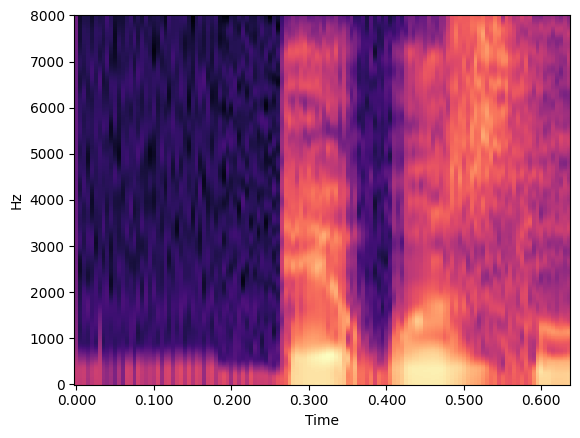

In [9]:
import numpy as np
from dataloader import AudioDataset
from torch.utils.data import DataLoader
import librosa

def test_dataset():
    dataset = AudioDataset('../data/vcc2016_training', batch_size=1, sr=16000)
    sample = dataset[0]

    sp = sample[0][2].squeeze()
    fs = 16000
    frame_period = 5.0

    # Use this in Ipython to see plot
    librosa.display.specshow(np.log(sp).T,
                            sr=fs,
                            hop_length=int(0.001 * fs * frame_period),
                            x_axis="time",
                            y_axis="linear",
                            cmap="magma")

test_dataset()


In [89]:
from dataloader import WorldDataset
from torch.utils.data import DataLoader

dataset = WorldDataset('../data/vcc2016_training', batch_size=1, sr=16000)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

def train(epochs):
  for i in range(epochs):
    print(f'Epoch {i}')
    iteration = 0
    for batch in train_dataloader:
      print(f'iteration {iteration}')
      
      # convert to float32 because model is defined this way
      source_features = batch[0][-1].to(dtype=torch.float32).transpose(1, 2)
      target_features = batch[1][-1].to(dtype=torch.float32).transpose(1, 2)

      loss = training_iteration(
                          x=source_features,
                          y=target_features,
                          optimizer=optimizer,
                          criterion=criterion,
                          Gx_y=cycleGAN.Gx_y,
                          Gy_x=cycleGAN.Gy_x,
                          Dx=cycleGAN.Dx,
                          Dy=cycleGAN.Dy)

      print(f'loss: {loss.item()}')
      iteration += 1

if train:
  train(epochs=100)

Epoch 0


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/lib/python3.10/random.py", line 325, in randrange
    istop = _index(stop)
TypeError: only integer scalar arrays can be converted to a scalar index

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marat/cyclegan-vc/venv/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/marat/cyclegan-vc/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/marat/cyclegan-vc/venv/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/marat/cyclegan-vc/src/dataloader.py", line 87, in __getitem__
    source_features[-1] = self.sample_mcep_segment(source_features[-1], self.n_frames)
  File "/home/marat/cyclegan-vc/src/dataloader.py", line 72, in sample_mcep_segment
    start = random.randint(0, mcep - n_frames)
  File "/usr/lib/python3.10/random.py", line 370, in randint
    return self.randrange(a, b+1)
  File "/usr/lib/python3.10/random.py", line 327, in randrange
    istop = int(stop)
TypeError: only size-1 arrays can be converted to Python scalars


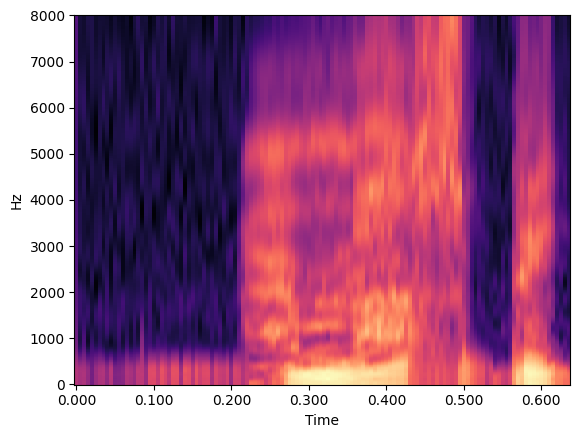

In [70]:
import pyworld as pw

batch = next(iter(train_dataloader))
source_features = batch[0]
source_mcep = source_features[-1]
source_mcep = source_mcep.to(dtype=torch.float32).transpose(1, 2)
output_mcep = cycleGAN.Gx_y.forward(source_mcep)

def render_sp(sp, fs, frame_period):
  # Use this in Ipython to see plot
  librosa.display.specshow(np.log(sp).T,
                          sr=fs,
                          hop_length=int(0.001 * fs * frame_period),
                          x_axis="time",
                          y_axis="linear",
                          cmap="magma")


def render_mcep_features(features, mcep):
  # Convert source mel-cepstral coefficients to spectrogram
  f0 = features[0].numpy()
  time_axis = features[1].numpy()
  ap = features[3].numpy()
  fs = 16000
  mcep = mcep.squeeze().transpose(-2, -1).to(dtype=torch.float64).contiguous()

  sp = pw.decode_spectral_envelope(mcep.numpy(), fs, fft_size=1024)

  frame_period = 5.0

  render_sp(sp, fs, frame_period)

render_mcep_features(features=target_features, mcep=source_mcep)

In [20]:
# Save state dict of cycleGAN
torch.save(cycleGAN.state_dict(), './cycleGAN.pt')

# Load state dict of cycleGAN
cycleGAN_loaded = CycleGAN()
cycleGAN_loaded.load_state_dict(torch.load('./cycleGAN.pt'))
cycleGAN_loaded.eval()
cycleGAN_original = cycleGAN

cycleGAN = cycleGAN_loaded

CycleGAN(
  (Gx_y): Generator(
    (conv1): Conv1d(24, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (glu): GLU(dim=1)
    (downsample_twice): Sequential(
      (0): Downsample(
        (conv): Conv1d(64, 256, kernel_size=(5,), stride=(2,), padding=(2,))
        (norm): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (glu): GLU(dim=1)
      )
      (1): Downsample(
        (conv): Conv1d(128, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
        (norm): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (glu): GLU(dim=1)
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=same)
        (norm1): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (glu): GLU(dim=1)
        (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=same)
        (

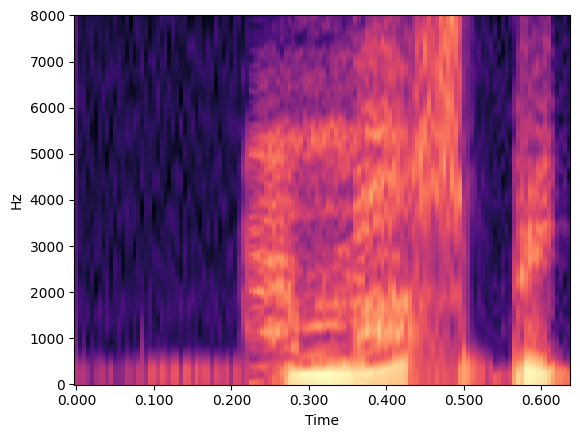

In [21]:
render_sp(source_features[2].squeeze().numpy(), 16000, 5.0)

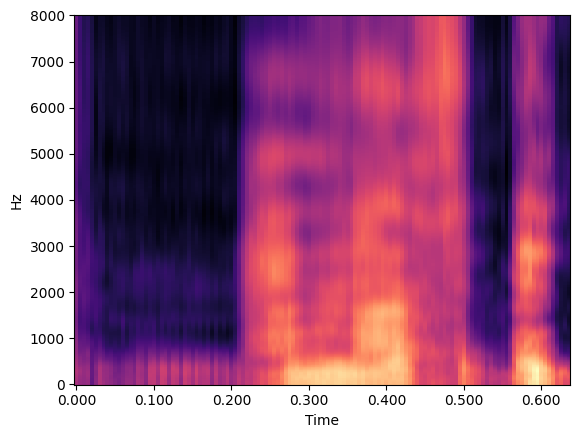

In [22]:
render_mcep_features(features=source_features, mcep=output_mcep.detach())

In [86]:
dataset = AudioDataset('../data/vcc2016_training', batch_size=1, sr=16000, n_frames=512)
eval_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
iterator = iter(eval_dataloader)

source_features, target_features = next(iterator)
print(source_features[-1].size())

output_mcep = cycleGAN.Gx_y.forward(source_features[-1].to(torch.float32).transpose(1, 2))
print(output_mcep.size())


torch.Size([1, 293, 24])
torch.Size([1, 24, 296])


In [87]:
def synthesize_mcep(f0, sp, ap, mcep, fs, frame_period):
  sp = pw.decode_spectral_envelope(mcep.numpy(), fs, fft_size=1024)
  y = pw.synthesize(f0, sp, ap, fs, frame_period)
  return y

f0 = source_features[0].squeeze(0).numpy()
sp = source_features[2].squeeze(0).numpy()
ap = source_features[3].squeeze(0).numpy()
print(f0.shape)
print(sp.shape)
print(ap.shape)
print(output_mcep.shape)

fs = 16000
frame_period = 5.0
mcep = output_mcep[-1].squeeze(0).transpose(-2, -1).to(dtype=torch.float64).contiguous().detach()
# mcep = source_features[-1].squeeze().detach()
# print(output_mcep.shape)
print(mcep.shape)
wav = synthesize_mcep(f0, sp, ap, mcep, fs, frame_period)

import soundfile as sf
sf.write('test.wav', wav, 16000)

(293,)
(293, 513)
(293, 513)
torch.Size([1, 24, 296])
torch.Size([296, 24])


ValueError: Mismatched number of frames between F0 (293), spectrogram (296) and aperiodicty (293)